# Cài đặt các thư viện cần thiết

In [1]:
!pip install transformers datasets
!pip install scikit-learn pandas seaborn

# Load và xử lý dữ liệu

In [2]:
import json
import pandas as pd

# Đọc các file JSON
def load_data(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

train_df = load_data("/content/train.json")
val_df = load_data("/content/val.json")
test_df = load_data("/content/test.json")

# Gán nhãn số
label2id = {"SUPPORTS": 0, "REFUTES": 1}
train_df["label"] = train_df["label"].map(label2id)
val_df["label"] = val_df["label"].map(label2id)
test_df["label"] = test_df["label"].map(label2id)

# Token hóa và chuyển sang Dataset

In [15]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

def preprocess(example):
    encoding = tokenizer(
        f"{example['claim']} {example['evidence']}",
        truncation=True,
        padding="max_length",
        max_length=256
    )
    encoding['label'] = example['label']
    return encoding


train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

Map:   0%|          | 0/9665 [00:00<?, ? examples/s]

Map:   0%|          | 0/1208 [00:00<?, ? examples/s]

Map:   0%|          | 0/1209 [00:00<?, ? examples/s]

In [18]:
print("Số mẫu train:", len(train_dataset))
print("Cột có trong train dataset:", train_dataset.column_names)

Số mẫu train: 9665
Cột có trong train dataset: ['claim', 'evidence', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


# Huấn luyện mô hình PhoBERT

In [20]:
from transformers import AutoTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
import os

# Khởi tạo tokenizer và model
class FactCheckingModelTrainer:
    def __init__(self, model_name="vinai/phobert-base", num_labels=2, max_length=256):
        self.model_name = model_name
        self.num_labels = num_labels
        self.max_length = max_length
        self.best_metric = float('-inf')

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=False)
        self.model = RobertaForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.trainer = None

    @staticmethod
    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    def fit(self,
        train_dataset,
        valid_dataset=None,
        output_dir='./results_phobert',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_steps=100,
        metric_for_best_model="f1"):

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_train_epochs,
            per_device_train_batch_size=per_device_train_batch_size,
            per_device_eval_batch_size=per_device_eval_batch_size,
            learning_rate=2e-5,
            warmup_ratio=0.1,
            weight_decay=weight_decay,
            logging_dir=f'{output_dir}/logs',
            logging_steps=logging_steps,
            save_steps=500,
            save_total_limit=3,
            metric_for_best_model=metric_for_best_model,
            greater_is_better=True,
            disable_tqdm=False,
            report_to="none",
            max_grad_norm=1.0
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            compute_metrics=self.compute_metrics if valid_dataset is not None else None,
        )

        print("Bắt đầu huấn luyện mô hình...")
        self.trainer.train()
        print("Huấn luyện hoàn tất.")

        if valid_dataset is not None:
            print("\nĐánh giá trên tập validation:")
            eval_results = self.trainer.evaluate()
            print("\nKết quả đánh giá:")
            print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
            print(f"F1-score: {eval_results['eval_f1']:.4f}")
            print(f"Precision: {eval_results['eval_precision']:.4f}")
            print(f"Recall: {eval_results['eval_recall']:.4f}")

    def predict(self, statement, evidence):
        self.model.eval()
        full_text = f"{statement} </s> {evidence}"

        inputs = self.tokenizer(
            full_text,
            return_tensors="pt",
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class_id = torch.argmax(probabilities, dim=1).item()
        label_map = {0: "SUPPORTS", 1: "REFUTES"}
        predicted_label = label_map.get(predicted_class_id, str(predicted_class_id))
        return predicted_label, probabilities.cpu().numpy()[0]

    def save_model(self, save_path="./fine_tuned_phobert_factcheck"):
        print(f"Lưu mô hình vào {save_path}")
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)


In [21]:
class FactCheckDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [24]:
trainer = FactCheckingModelTrainer()
trainer.fit(train_dataset, valid_dataset=val_dataset)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bắt đầu huấn luyện mô hình...


Step,Training Loss
100,0.683700
200,0.682000
300,0.528200
400,0.476100
500,0.443300
600,0.427900
700,0.405500
800,0.391300
900,0.426600
1000,0.368300


Huấn luyện hoàn tất.

Đánh giá trên tập validation:



Kết quả đánh giá:
Accuracy: 0.9040
F1-score: 0.9042
Precision: 0.9058
Recall: 0.9040


# Hàm đánh giá test_evaluate

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_on_testset(trainer, test_dataset, label_names=["SUPPORTS", "REFUTES"]):
    print("📊 Đang đánh giá trên tập test...")
    predictions = trainer.trainer.predict(test_dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)

    # In báo cáo phân loại
    print("\n=== Báo cáo phân loại ===")
    print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)

    # Vẽ biểu đồ
    plt.figure(figsize=(6, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title("🔍 Ma trận nhầm lẫn trên tập test")
    plt.tight_layout()
    plt.show()

📊 Đang đánh giá trên tập test...



=== Báo cáo phân loại ===
              precision    recall  f1-score   support

    SUPPORTS     0.9195    0.9209    0.9202       670
     REFUTES     0.9015    0.8998    0.9006       539

    accuracy                         0.9115      1209
   macro avg     0.9105    0.9104    0.9104      1209
weighted avg     0.9115    0.9115    0.9115      1209



<ipython-input-25-a692662f71c8>:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


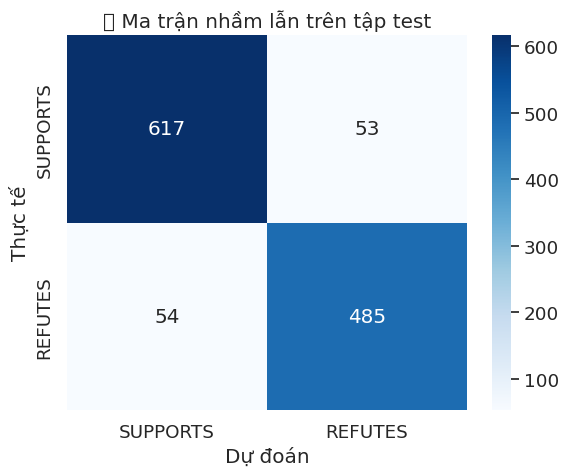

In [26]:
evaluate_on_testset(trainer, test_dataset, label_names=["SUPPORTS", "REFUTES"])